In [16]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import pylab as pl
import os
import numpy as np
import zipfile
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# importing, cleaning, and merging data

In [17]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
nrg_clean = nrg[['BBL','Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
nrg_clean = nrg_clean.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)': 'Floor Area (ft²)'})
nrg_clean.head()

,BBL,Site EUI(kBtu/ft2),Floor Area (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000


In [18]:
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/mn_mappluto_16v2/MNMapPLUTO.shp")
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot', 
            'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 
            'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 
            'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand', 
            'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 
            'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea', 'LotDepth', 
            'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F', 'NumBldgs', 'NumFloors', 'OfficeArea', 
            'OtherArea', 'Overlay1', 'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct', 
            'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area', 'SHAPE_Leng', 'SPDist1', 
            'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SPDist3',
            'SplitZone', 'StrgeArea', 'TaxMap', 'Tract2010', 'Version', 'XCoord', 'YCoord', 
            'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode', 'ZoneDist1', 'ZoneDist2', 
            'ZoneDist3', 'ZoneDist4', 'ZoneMap', 'geometry'], axis=1, inplace=True)
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1987,1.000090e+09
2,500,602,1902,1.000158e+09
3,0,50,1900,1.000130e+09
4,0,0,1900,1.000010e+09


In [19]:
df = pd.merge(nrg_clean, bsize, on='BBL').dropna()
df['Site EUI(kBtu/ft2)'] = pd.to_numeric(df['Site EUI(kBtu/ft2)'], errors='coerce')
df.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,BBL,Site EUI(kBtu/ft2),Floor Area (ft²),UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000,0,56,1977
10,1.010140e+09,154.9,841709,0,2,1999
15,1.007660e+09,122.3,59468,0,8,1912
16,1.008150e+09,117.0,364000,0,24,1954
18,1.005050e+09,82.1,235370,0,24,1926


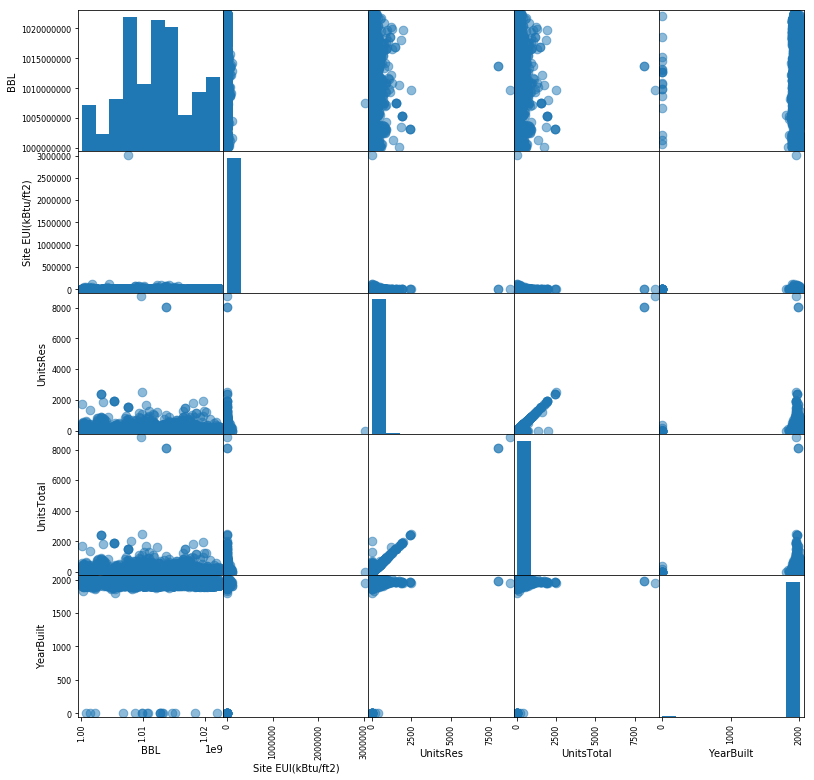

In [20]:
scatter_matrix (df, s=300, figsize=(13, 13));

# figure 1 above shows a mapping of each variable against all other variables (of particular interest are the plots showing energy vs units and vice versa)

# plotting energy vs units

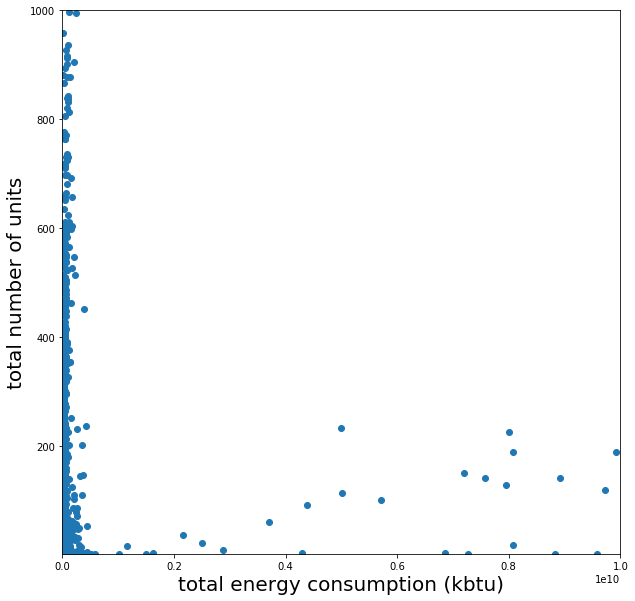

In [22]:
df['Floor Area (ft²)'] = pd.to_numeric(df['Floor Area (ft²)'], errors='coerce')
df['nrgTotal'] = df['Site EUI(kBtu/ft2)'] * df['Floor Area (ft²)']

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(df['nrgTotal'], df['UnitsTotal'])
ax.set_xlim(xmin=1000, xmax=1e10)
ax.set_ylim(ymin=1, ymax=1000)
ax.set_xlabel("total energy consumption (kbtu)", fontsize=20)
ax.set_ylabel("total number of units", fontsize=20);

# figure 2 above shows the total number of units in a building against that building's total energy consumption

# cutting data and plotting again

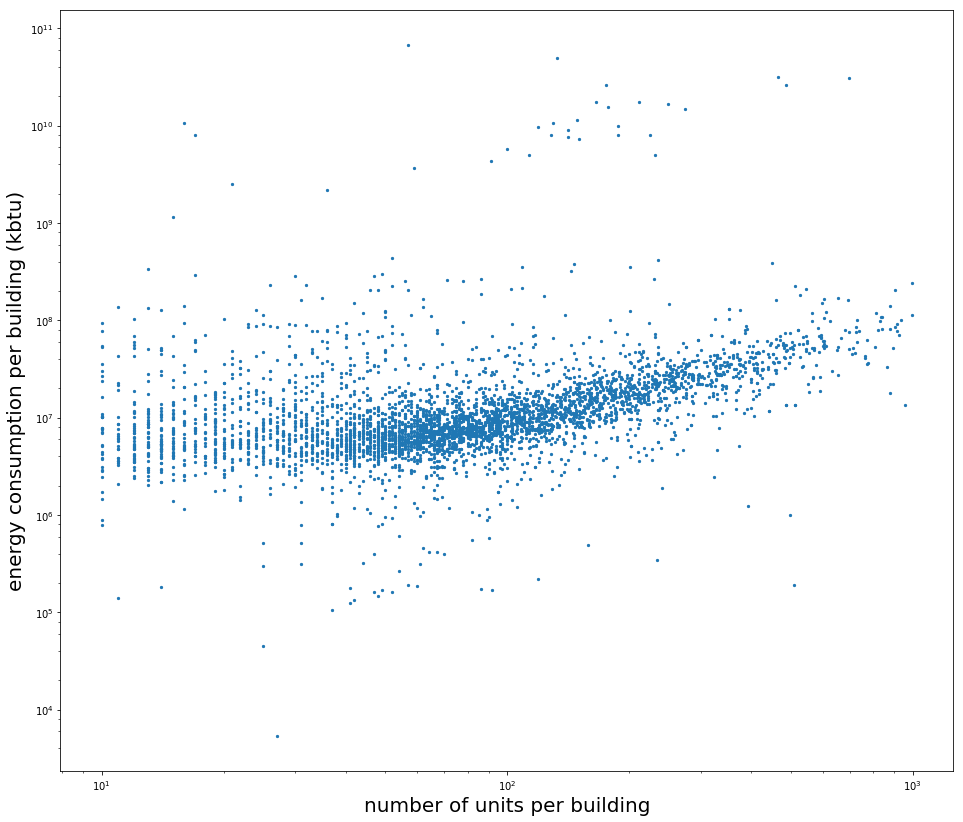

In [24]:
dfCut = df[(df.nrgTotal > 1000) * (df.UnitsTotal>=10) * 
                           (df.UnitsTotal<1000)]

ax = dfCut.plot(kind='scatter', y='nrgTotal', x='UnitsTotal', 
                   marker='.',  figsize=(16, 14), loglog=True)
ax.set_xlabel("number of units per building", fontsize=20)
ax.set_ylabel("energy consumption per building (kbtu)", fontsize=20);

# figure 3 above shows a close-up of the data, which was obtained by looking at the log of the data (this is better for visualizing the total energy consumed per number of units)

# fitting a line to the data

In [26]:
x = dfCut['UnitsTotal']
y = dfCut['nrgTotal']

#fitting energy against units
X1 = sm.add_constant(np.log10(x))
linmodelEnergy = sm.OLS(np.log10(y), X1, missing='drop').fit()

#fitting units against energy
X2 = sm.add_constant(np.log10(y))
linmodelUnits = sm.OLS(np.log10(x), X2, missing='drop').fit()

# plotting energy against units

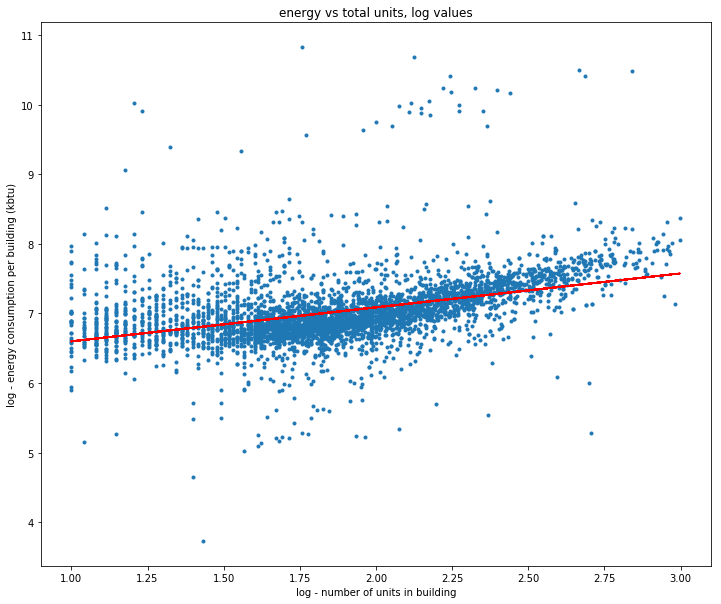

In [28]:
lm_E = linmodelEnergy.fittedvalues

fig = plt.figure(figsize = (12,10))
plot(np.log10(x), np.log10(y), '.')
plot(np.log10(x), lm_E, c = 'r')
pl.title('energy vs total units, log values')
pl.xlabel('log - number of units in building')
pl.ylabel('log - energy consumption per building (kbtu)');

# figure 4 above shows the logarithmic linear regression of energy consumption as determined by the number of units in a building (there appears to be a fairly well-fitted linear model to the data)

In [32]:
linmodelEnergy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nrgTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          2.05e-166
Time:                        22:03:43   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1110      0.033    187.012      0.000         6.047     6.175
UnitsTotal     0.4882      0.017     28.761      0.000         0.455     0.521
==============================================================================
Omnibus:                     2264.923   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44888.937
Skew:                           2.089   Prob(JB):                         0.00
Kurtosis:                      18.333   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# plotting units against energy

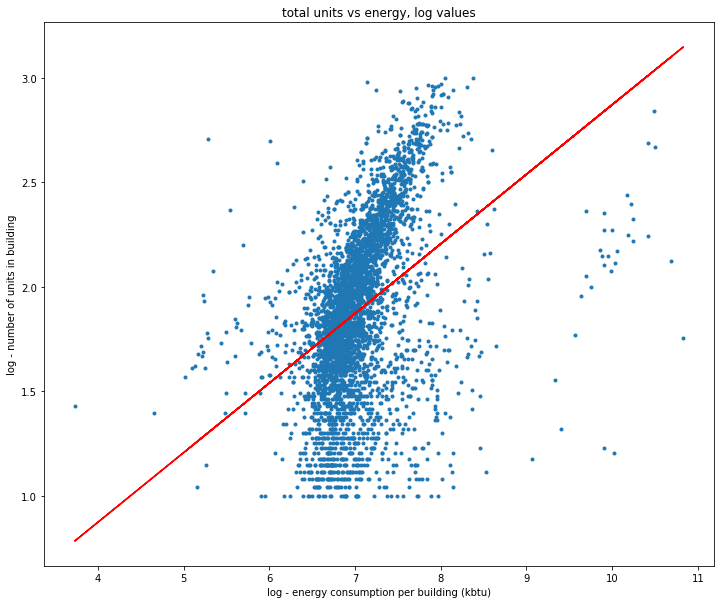

In [33]:
lm_U = linmodelUnits.fittedvalues

fig = plt.figure(figsize = (12,10))
plot(np.log10(y), np.log10(x), '.')
plot(np.log10(y), lm_U, c = 'r')
pl.title('total units vs energy, log values')
pl.xlabel('log - energy consumption per building (kbtu)')
pl.ylabel('log - number of units in building');

# figure 5 above shows the logarithmic linear regression of total number of units as determined by the energy consumed by a building (this appears to be a faulty model)

In [34]:
linmodelUnits.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          2.05e-166
Time:                        22:05:48   Log-Likelihood:                -1746.4
No. Observations:                4266   AIC:                             3497.
Df Residuals:                    4264   BIC:                             3510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4563      0.082     -5.596      0.000        -0.616    -0.296
nrgTotal       0.3328      0.012     28.761      0.000         0.310     0.356
==============================================================================
Omnibus:                      149.498   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.251
Skew:                          -0.464   Prob(JB):                     1.31e-36
Kurtosis:                       3.260   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# chi-square test

In [35]:
#defining the chi-square test
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((model - data)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [36]:
#calculating the errors
errorsEnergy = np.sqrt((dfCut['Floor Area (ft²)'])**2 + (dfCut['Site EUI(kBtu/ft2)']**2))
errorsUnits = np.sqrt(dfCut['UnitsTotal'])

#propagating the errors through a log
errorsInLogEnergy = np.abs(errorsEnergy / dfCut.nrgTotal / np.log(10))
errorsInLogUnits = np.abs(errorsUnits / dfCut.UnitsTotal / np.log(10))

# above, the pythagorean theorem was used to calculate the value of errors in total energy - this is done because the calculation of total energy is a product of two variables, both of which could contain their own errors (in using the pythagorean theorem, we are essentially identifying the resulting hypotenuse that forms from both variables' potential errors)

In [37]:
#running the chi-square test on the unit model
print(chi2(np.log10(dfCut['UnitsTotal']), lm_U, errorsInLogUnits))

485793.290042


# fitting a second degree model for energy vs units

In [38]:
qm = smf.ols("nrgTotal ~ UnitsTotal + I(UnitsTotal**2)", data = dfCut).fit()

In [39]:
qm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nrgTotal   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.980
Date:                Mon, 23 Oct 2017   Prob (F-statistic):           0.000941
Time:                        22:25:32   Log-Likelihood:                -96786.
No. Observations:                4266   AIC:                         1.936e+05
Df Residuals:                    4263   BIC:                         1.936e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           5.205e+06   4.72e+07      0.110      0.912     -8.74e+07  9.78e+07
UnitsTotal          1.201e+06   5.07e+05      2.368      0.018      2.06e+05   2.2e+06
I(UnitsTotal ** 2)  -761.5588    786.484     -0.968      0.333     -2303.476   780.359
==============================================================================
Omnibus:                    10366.381   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        111091955.133
Skew:                          25.202   Prob(JB):                         0.00
Kurtosis:                     791.955   Cond. No.                     1.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

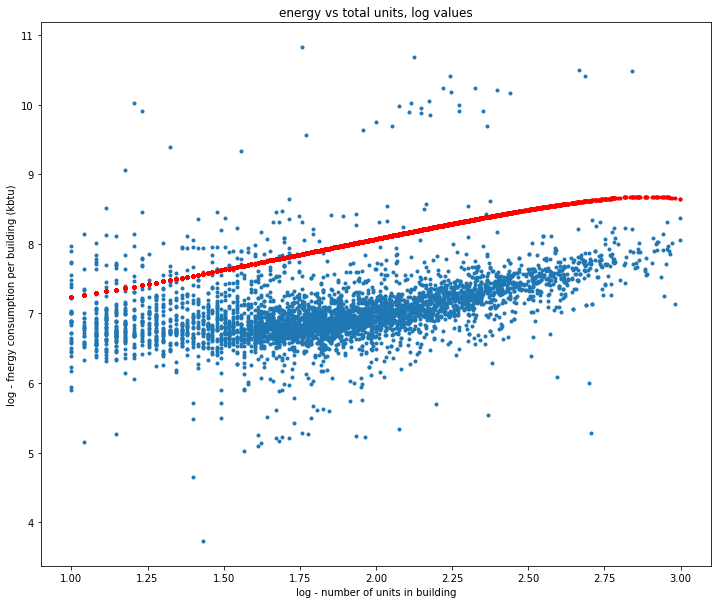

In [40]:
qm_E = qm.fittedvalues
x = dfCut['UnitsTotal']
y = dfCut['nrgTotal']

fig = plt.figure(figsize = (12,10))
plot(np.log10(x), np.log10(y), '.')
plot(np.log10(x), np.log10(qm_E), '.', c = 'r')
pl.title('energy vs total units, log values')
pl.xlabel('log - number of units in building')
pl.ylabel('log - fnergy consumption per building (kbtu)');

# figure 6 above shows the quadratic model fitted against the logarithmic plot of energy vs total units

# testing the models with the lr test

In [41]:
qm.compare_lr_test(linmodelEnergy)

(-188445.87256168874, 1.0, 1.0)

# from the lr test above, we cannot reject the null hypothesis, thus the simpler linear model if preferred

# fitting a second degree model for units vs energy

In [42]:
qmU = smf.ols("UnitsTotal ~ nrgTotal + I(nrgTotal**2)", data = dfCut).fit()

In [43]:
qmU.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                      -0.822
Model:                            OLS   Adj. R-squared:                 -0.823
Method:                 Least Squares   F-statistic:                    -1924.
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               1.00
Time:                        22:31:36   Log-Likelihood:                -27986.
No. Observations:                4266   AIC:                         5.598e+04
Df Residuals:                    4264   BIC:                         5.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         3.053e-18      4e-19      7.625      0.000      2.27e-18  3.84e-18
nrgTotal          2.624e-08   3.44e-09      7.625      0.000      1.95e-08   3.3e-08
I(nrgTotal ** 2) -3.991e-19   7.08e-20     -5.641      0.000     -5.38e-19  -2.6e-19
==============================================================================
Omnibus:                     2528.767   Durbin-Watson:                   0.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23579.733
Skew:                           2.745   Prob(JB):                         0.00
Kurtosis:                      13.126   Cond. No.                     8.47e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.47e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

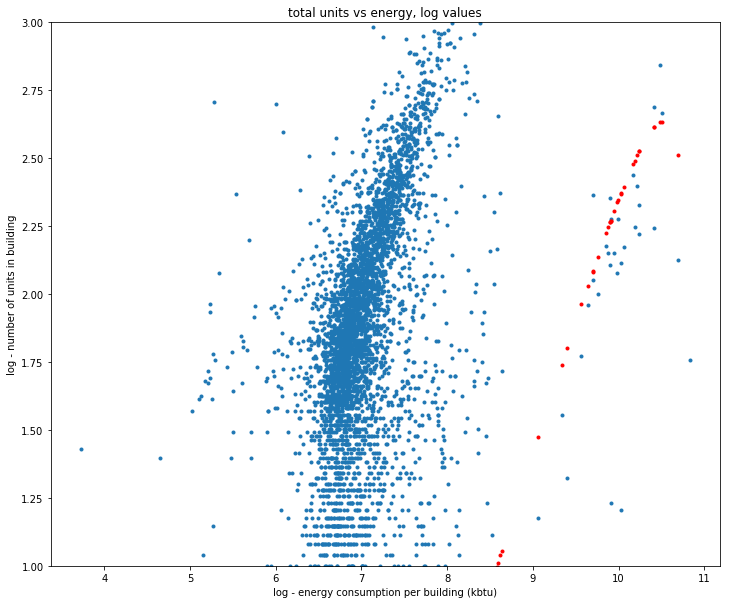

In [44]:
qm_U = qmU.fittedvalues
y = dfCut['UnitsTotal']
x = dfCut['nrgTotal']

fig = plt.figure(figsize = (12,10))
plot(np.log10(x), np.log10(y), '.')
plot(np.log10(x), np.log10(qm_U), '.',c = 'r')
pl.title('total units vs energy, log values')
pl.xlabel('log - energy consumption per building (kbtu)')
pl.ylim((1,3))
pl.ylabel('log - number of units in building');

# figure 7 above shows the quadratic model fitted against the logarithmic plot of total units vs energy

# here, the lr test does not return a p-value